# Neural Network for Time-Stepping Prediction of Buildings

In [1]:
from PIL import Image

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from scipy import signal
# import math
# import os
import timeit

import matplotlib.pyplot as plt
import pandas as pd
import random
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve, precision_score, recall_score, f1_score

import seaborn as sn

from sklearn.preprocessing import StandardScaler
import shap

from tradnet import *

## Set Inputs

In [2]:
seed = 7
n_samples = 10000
num_metaims = 5             # NOTE: Here this variable denotes the number of Intensity Measures to use

In [3]:
path_to_predictor_dataset = 'predictors_new.parquet'           # Set the path to your analysis data file (csv/parquet)
path_to_pga_dataset = '../../RC_Frame_large/pga_all_new.parquet'
path_to_processed_time_histories = '../../RC_Frame_large/x_gm'                  # Set the path to your ground motions file

## Read Inputs

In [4]:
cols2read = ['storeys', 'bays', 'storey_ht', 'bay_width', 'w_floor', 
             'f_c', 'gm_index', 'pga', 'pgv', 'drift_ratio_pct_max', 'damage_state']

predictors_all = pd.read_parquet(path_to_predictor_dataset, columns = cols2read, engine = 'pyarrow')
# predictors_all = predictors_all[predictors_all['tip_displacement']<48].reset_index(drop = True)

predictors_all['building_ht'] = predictors_all['storeys'] * predictors_all['storey_ht']
predictors_all['building_width'] = predictors_all['bays'] * predictors_all['bay_width']

In [5]:
pga_all = pd.read_parquet(path_to_pga_dataset, engine = 'pyarrow')
predictors_all = predictors_all.merge(pga_all[['sa01', 'sa02', 'sa03', 'sa06', 'sa10', 'sa20', 'arias', 'sed', 'cav', 'ASI_05', 'ASI_10']], 
                                      left_on = 'gm_index', right_index = True)

We assume the collapse capacity of the building to be 12 inches

In [6]:
# # capacity = predictors_all['tip_displacement'].quantile(0.95)
# capacity = 12
# predictors_all['capacity'] = capacity
# predictors_all['damage_state'] = 0

# predictors_all.loc[predictors_all['tip_displacement']>predictors_all['capacity'], 'damage_state'] = 1

# predictors_all = predictors_all.drop(columns = ['storeys', 'storey_ht', 'bays', 'bay_width', 'capacity'])

## Extract Ground Motion Features

In [7]:
# Define the Autoencoder model using PyTorch
class Autoencoder(nn.Module):
    def __init__(self, input_size, reduced_size, hidden_size):
        super(Autoencoder, self).__init__()
        activation = nn.ELU
        
        self.encoder = nn.Sequential(
            nn.Linear(input_size, hidden_size),  # Encoder layer
            activation(),
            nn.Linear(hidden_size, hidden_size),  # Encoder layer
            activation(),
            nn.Linear(hidden_size, hidden_size),  # Encoder layer
            activation(),
            nn.Linear(hidden_size, hidden_size),  # Encoder layer
            activation(),
            nn.Linear(hidden_size, hidden_size),  # Encoder layer
            activation(),            
            nn.Linear(hidden_size, reduced_size),  # Encoder layer
            # activation()
        )
        self.decoder = nn.Sequential(
            nn.Linear(reduced_size, hidden_size),  # Encoder layer
            activation(),
            nn.Linear(hidden_size, hidden_size),  # Encoder layer
            activation(),
            nn.Linear(hidden_size, hidden_size),  # Encoder layer
            activation(),
            nn.Linear(hidden_size, hidden_size),  # Encoder layer
            activation(),
            nn.Linear(hidden_size, hidden_size),  # Encoder layer
            activation(),
            nn.Linear(hidden_size, input_size),  # Decoder layer
            # activation()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
    
def get_gm_tensors(train_data, val_data, test_data, path_to_processed_time_histories):
    gm_sequence_train = np.sort(train_data['gm_index'].unique())
    gm_sequence_train_df = pd.DataFrame(gm_sequence_train, columns = ['gm_index_old'])
    gm_sequence_train_df['gm_ind_new'] = gm_sequence_train_df.index
    train_data = pd.merge(train_data, gm_sequence_train_df, left_on = 'gm_index', right_on = 'gm_index_old')
    
    gm_sequence_val = np.sort(val_data['gm_index'].unique())
    gm_sequence_val_df = pd.DataFrame(gm_sequence_val, columns = ['gm_index_old'])
    gm_sequence_val_df['gm_ind_new'] = gm_sequence_val_df.index
    val_data = pd.merge(val_data, gm_sequence_val_df, left_on = 'gm_index', right_on = 'gm_index_old')
    
    gm_sequence_test = np.sort(test_data['gm_index'].unique())
    gm_sequence_test_df = pd.DataFrame(gm_sequence_test, columns = ['gm_index_old'])
    gm_sequence_test_df['gm_ind_new'] = gm_sequence_test_df.index
    test_data = pd.merge(test_data, gm_sequence_test_df, left_on = 'gm_index', right_on = 'gm_index_old')
    
    # Load the ground motions
    x_th_all = torch.load(path_to_processed_time_histories)
    x_th_all = torch.tensor(x_th_all, dtype=torch.float32)
    
    x_th = x_th_all[gm_sequence_train, :]
    x_th_val = x_th_all[gm_sequence_val, :]
    x_th_test = x_th_all[gm_sequence_test, :]
    
    return x_th, x_th_val, x_th_test, train_data, val_data, test_data

def train_AED_gm_features(x_th, reduced_size = 5, hidden_size = 256, num_epochs = 1000):
    autoencoder = Autoencoder(input_size = x_th.shape[1], 
                              reduced_size = reduced_size, 
                              hidden_size = hidden_size)

    # Define the loss function and optimizer for the autoencoder
    criterion = nn.MSELoss()
    autoencoder_optimizer = optim.Adam(autoencoder.parameters(), lr=1e-3)

    # Train the Autoencoder
    start = timeit.default_timer()
    for epoch in range(num_epochs):

        inputs = x_th
        autoencoder_optimizer.zero_grad()
        outputs = autoencoder(inputs)
        loss = criterion(outputs, inputs)
        loss.backward()
        autoencoder_optimizer.step()
        if (epoch+1) % 50 != 0:
            continue
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.6f}')

    stop = timeit.default_timer()
    
    print('Time Elapsed in AED Training: ', stop - start)
    
    return autoencoder

def extract_gm_features(autoencoder, x_th):
    # Extract encoded features
    encoded_features = autoencoder.encoder(x_th).detach()
    
    n_features = encoded_features.shape[1]
    
    pca_df = pd.DataFrame(encoded_features, 
                          columns = ['encoded_{}'.format(i+1) for i in range(n_features)])
    pca_df['gm_index'] = pca_df.index
    
    return pca_df

def get_features_AED(train_data, val_data, test_data, path_to_processed_time_histories, reduced_size = 5):
    x_th, x_th_val, x_th_test, train_data, val_data, test_data = get_gm_tensors(train_data, 
                                                                                val_data, 
                                                                                test_data,
                                                                                path_to_processed_time_histories)
    
    autoencoder = train_AED_gm_features(x_th, 
                                        reduced_size, 
                                        hidden_size = 256, 
                                        num_epochs = 1000)
    
    pca_df_train = extract_gm_features(autoencoder, x_th)
    pca_df_val = extract_gm_features(autoencoder, x_th_val)
    pca_df_test = extract_gm_features(autoencoder, x_th_test)
    
    train_data = pd.merge(train_data, pca_df_train, left_on = 'gm_ind_new', right_on = 'gm_index')
    val_data = pd.merge(val_data, pca_df_val, left_on = 'gm_ind_new', right_on = 'gm_index')
    test_data = pd.merge(test_data, pca_df_test, left_on = 'gm_ind_new', right_on = 'gm_index')
        
    return train_data, val_data, test_data

## Prepare training data

In [8]:
train_data, val_data, test_data = create_train_val_test_splits(predictors_all, 
                                                               n_samples = n_samples, 
                                                               split_frac = 0.9, 
                                                               random_seed = seed)

# Extract GM features
train_data, val_data, test_data = get_features_AED(train_data, 
                                                   val_data, 
                                                   test_data, 
                                                   path_to_processed_time_histories,
                                                   reduced_size = num_metaims)

cols2scale = ['building_ht', 'building_width', 'w_floor', 'f_c']
cols_predicted = ['damage_state']

cols_gm = ['encoded_{}'.format(i+1) for i in range(num_metaims)]




/tmp/ipykernel_37087/4129954234.py:59: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_th_all = torch.tensor(x_th_all, dtype=torch.float32)


Epoch [50/1000], Loss: 0.005145
Epoch [100/1000], Loss: 0.004721
Epoch [150/1000], Loss: 0.004021
Epoch [200/1000], Loss: 0.003284
Epoch [250/1000], Loss: 0.002589
Epoch [300/1000], Loss: 0.001886
Epoch [350/1000], Loss: 0.001349
Epoch [400/1000], Loss: 0.000831
Epoch [450/1000], Loss: 0.000451
Epoch [500/1000], Loss: 0.000224
Epoch [550/1000], Loss: 0.000114
Epoch [600/1000], Loss: 0.000059
Epoch [650/1000], Loss: 0.000050
Epoch [700/1000], Loss: 0.000044
Epoch [750/1000], Loss: 0.000033
Epoch [800/1000], Loss: 0.000021
Epoch [850/1000], Loss: 0.000016
Epoch [900/1000], Loss: 0.000012
Epoch [950/1000], Loss: 0.000008
Epoch [1000/1000], Loss: 0.000007
Time Elapsed in AED Training:  2287.1182078188285


In [9]:
x_data, x_val, x_test, y_data, y_val, y_test = create_scaled_inputs_outputs(train_data, 
                                                                            val_data, 
                                                                            test_data, 
                                                                            cols2scale, 
                                                                            cols_gm)

## Train TradNet-AED Model

In [10]:
max_epochs = 1200
interval = 50

start = timeit.default_timer()
model, error_evolution_training, error_evolution_val = train_tradnet_model(x_data, 
                                                                      x_val, 
                                                                      y_data, 
                                                                      y_val, 
                                                                      train_data, 
                                                                      val_data,
                                                                      max_epochs = max_epochs,
                                                                      interval = interval,
                                                                      alpha = 1e-3,
                                                                      nlayers = 3,
                                                                      nhidden = 24)
stop = timeit.default_timer()

Epoch 1: Training BCE Loss 0.8520, Validation BCE Loss 0.8500
Epoch 50: Training BCE Loss 0.7349, Validation BCE Loss 0.7319
Epoch 100: Training BCE Loss 0.5912, Validation BCE Loss 0.5935
Epoch 150: Training BCE Loss 0.5080, Validation BCE Loss 0.5218
Epoch 200: Training BCE Loss 0.4603, Validation BCE Loss 0.4845
Epoch 250: Training BCE Loss 0.4320, Validation BCE Loss 0.4640
Epoch 300: Training BCE Loss 0.4138, Validation BCE Loss 0.4504
Epoch 350: Training BCE Loss 0.4000, Validation BCE Loss 0.4393
Epoch 400: Training BCE Loss 0.3872, Validation BCE Loss 0.4285
Epoch 450: Training BCE Loss 0.3750, Validation BCE Loss 0.4196
Epoch 500: Training BCE Loss 0.3641, Validation BCE Loss 0.4121
Epoch 550: Training BCE Loss 0.3561, Validation BCE Loss 0.4094
Epoch 600: Training BCE Loss 0.3477, Validation BCE Loss 0.4072
Epoch 650: Training BCE Loss 0.3418, Validation BCE Loss 0.4060
Epoch 700: Training BCE Loss 0.3365, Validation BCE Loss 0.4049
Epoch 750: Training BCE Loss 0.3320, Valida

In [11]:
print('Time Elapsed in Model Training: ', stop - start)

Time Elapsed in Model Training:  5.842811633367091


In [12]:
y_pred_val = predict_tradnet(model, x_val)
val_data['damage_state_pred'] = y_pred_val.detach().view(-1).numpy()
val_data['damage_state_class_pred'] = val_data['damage_state_pred'].round().astype("int")

y_pred_train = predict_tradnet(model, x_data)
train_data['damage_state_pred'] = y_pred_train.detach().view(-1).numpy()
train_data['damage_state_class_pred'] = train_data['damage_state_pred'].round().astype("int")

## Distribution of Responses

,Survived,Failed
Survived,0.941385,0.058615
Failed,0.073227,0.926773


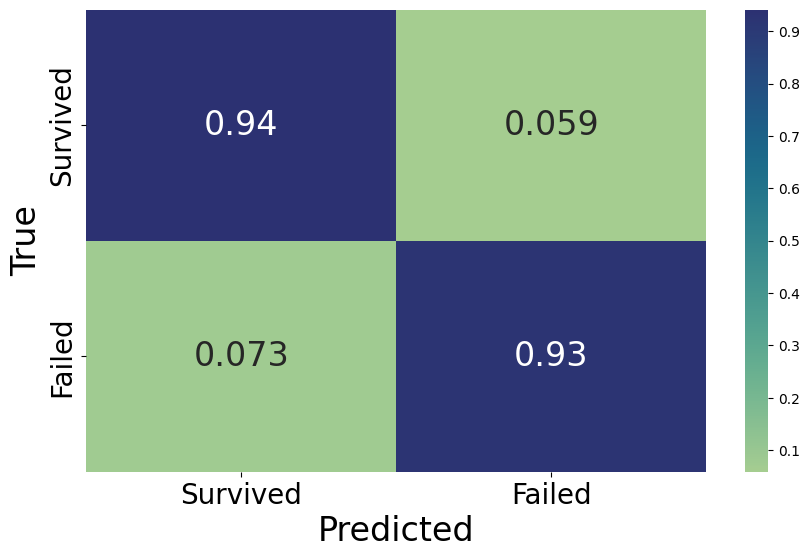

In [13]:
# constant for classes
classes = ('Survived', 'Failed')
plot_confusion(val_data, 'damage_state', 'damage_state_class_pred', classes)

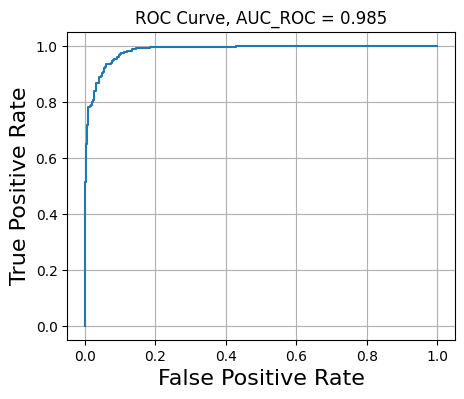

In [14]:
plot_auc_roc(val_data, 'damage_state', 'damage_state_pred')

,Survived,Failed
Survived,0.966199,0.033801
Failed,0.045674,0.954326


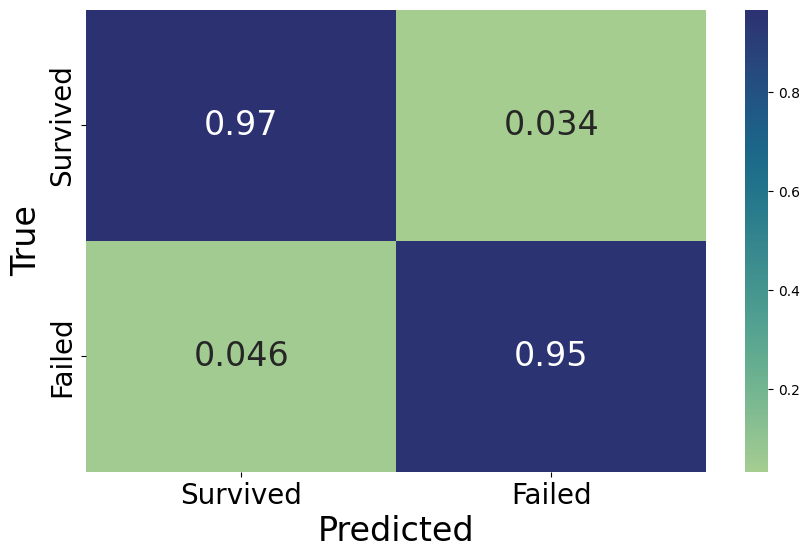

In [15]:
plot_confusion(train_data, 'damage_state', 'damage_state_class_pred', classes)

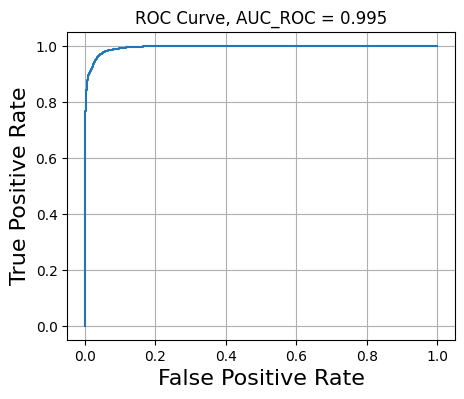

In [16]:
plot_auc_roc(train_data, 'damage_state', 'damage_state_pred')

## Loss Evolution

ValueError: x and y must have same first dimension, but have shapes (25,) and (1200,)

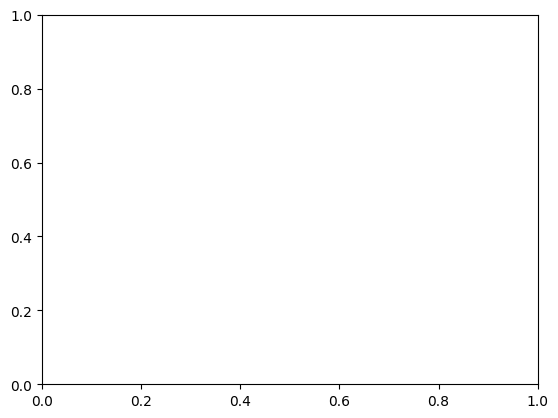

In [17]:
# Loss evolution curve
fig, ax = plt.subplots(1,1)
ax.plot(range(0, interval + max_epochs, interval), error_evolution_training, label = 'Training BCE Loss')
ax.plot(range(0, interval + max_epochs, interval), error_evolution_val, label = 'Validation BCE Loss')
# ax.set(title="Loss Evolution with Model Training", xlabel="Number of Epochs", ylabel="MSE Loss")
ax.set_title("Loss Evolution with Model Training", fontsize = 18)
ax.set_xlabel("Number of Epochs", fontsize = 18)
ax.set_ylabel("BCE Loss", fontsize = 18)
ax.legend()
ax.grid()
plt.show()

## Make Predictions on Test Data

In [18]:
y_pred_test = predict_tradnet(model, x_test)
test_data['damage_state_pred'] = y_pred_test.detach().view(-1).numpy()
test_data['damage_state_class_pred'] = test_data['damage_state_pred'].round().astype("int")

## Confusion Matrix on Test Data

,Survived,Failed
Survived,0.944250,0.055750
Failed,0.078419,0.921581


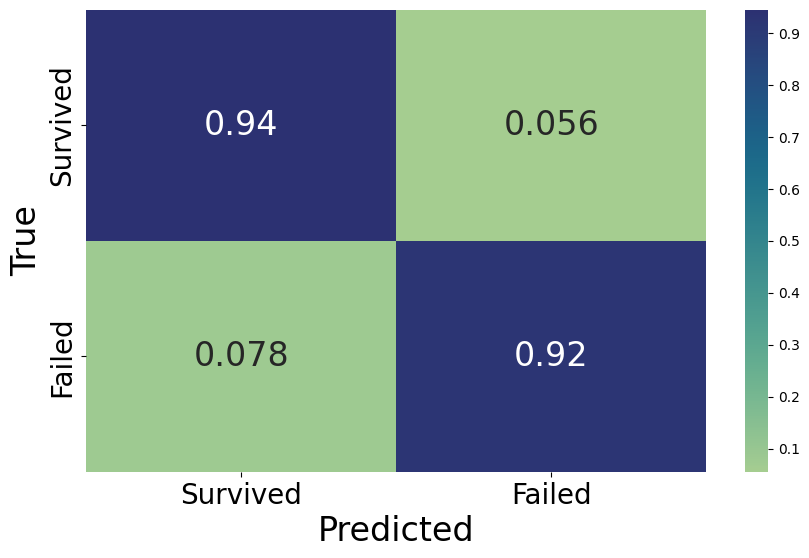

In [19]:
plot_confusion(test_data, 'damage_state', 'damage_state_class_pred', classes)

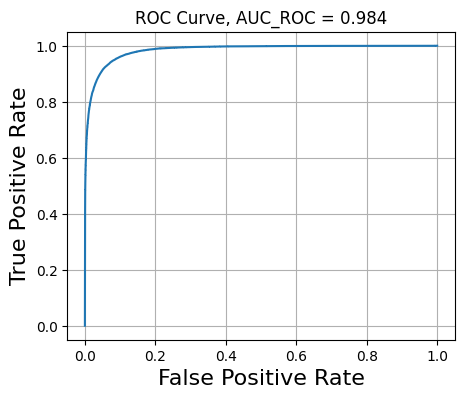

In [20]:
plot_auc_roc(test_data, 'damage_state', 'damage_state_pred')

In [21]:
accuracy_score(np.array(test_data['damage_state']), np.array(test_data['damage_state_class_pred']))

0.9343992536829967

In [22]:
roc_auc_score(np.array(test_data['damage_state']), np.array(test_data['damage_state_pred']))

0.9836914608208809

In [29]:
precision_score((test_data['damage_state']), np.array(test_data['damage_state_class_pred']))

0.9270267838397168

In [30]:
recall_score((test_data['damage_state']), np.array(test_data['damage_state_class_pred']))

0.9215814896535274

## Confusion Matrix on Combined Train, Validation, and Test Data

,Survived,Failed
Survived,0.946471,0.053529
Failed,0.074955,0.925045


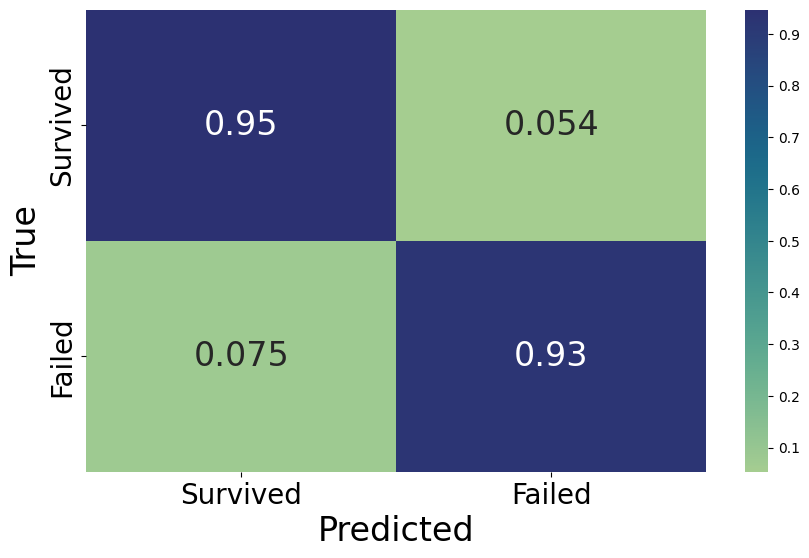

In [23]:
all_data = pd.concat([train_data, val_data, test_data]).reset_index(drop = True)
plot_confusion(all_data, 'damage_state', 'damage_state_class_pred', classes)

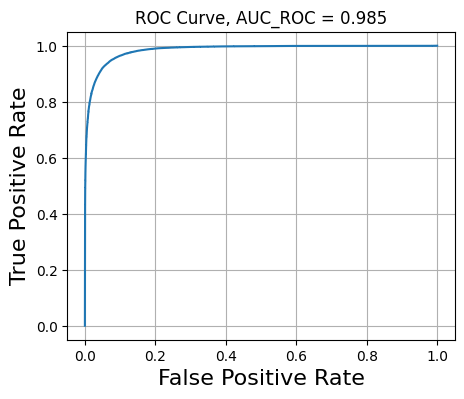

In [24]:
plot_auc_roc(all_data, 'damage_state', 'damage_state_pred')

## Compare Fragilities

In [25]:
fragility_df_gt = develop_fragility_model_stripe(all_data, 'pga', 'damage_state', bin_width = 0.1, 
                                                 max_im = 1.5, mu = 0.80, beta = 1.2)
fragility_df_pred = develop_fragility_model_stripe(all_data, 'pga', 'damage_state_class_pred', bin_width = 0.1, 
                                                   max_im = 1.5, mu = 0.80, beta = 1.2)

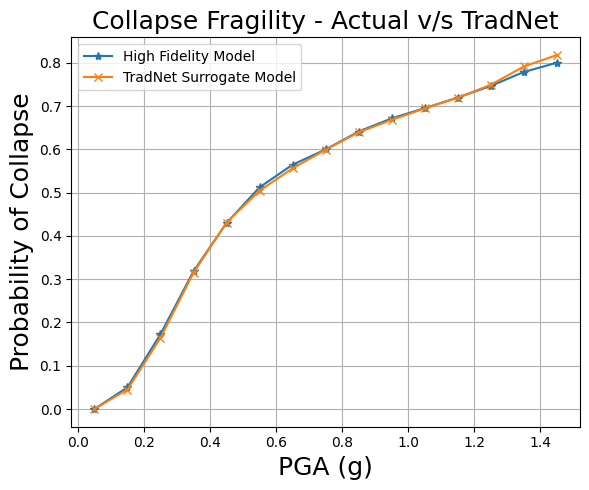

 Mean error = 0.007037, Max error = 0.017761


In [26]:
fig, ax = plt.subplots(1,1, figsize = (6, 5))

error_mean = (((fragility_df_gt['Probability'] - fragility_df_pred['Probability'])**2).mean())**0.5
error_max = (((fragility_df_gt['Probability'] - fragility_df_pred['Probability'])**2).max())**0.5

ax.plot(np.array(fragility_df_gt['IM']), np.array(fragility_df_gt['Probability']), '*-', label = 'High Fidelity Model')
ax.plot(np.array(fragility_df_pred['IM']), np.array(fragility_df_pred['Probability']), 'x-', label = 'TradNet Surrogate Model')
ax.legend()
ax.set_xlabel('PGA (g)', fontsize = 18)
ax.set_ylabel('Probability of Collapse', fontsize = 18)
ax.set_title('Collapse Fragility - Actual v/s TradNet', fontsize = 18)
ax.grid()

plt.tight_layout()
plt.show()

print(' Mean error = {}, Max error = {}'.format(round(error_mean,6), round(error_max,6)))

In [27]:
# fragility_df_pred.to_parquet('frag_df{}_tradnetaed_new.parquet'.format(len(cols_gm)), engine = 'pyarrow')

## Further Analysis

In [ ]:
# Predict using the trained model
# meta_im_cols = ['meta_im_{}'.format(i) for i in range(num_metaims)]
x_th = torch.tensor(all_data[cols_gm].values)

x_to_scale_train = torch.tensor(train_data[cols2scale].values)
scaler = StandardScaler()
scaler.fit(x_to_scale_train)

x_to_scale = torch.tensor(all_data[cols2scale].values)
x_scaled = torch.tensor(scaler.transform(x_to_scale))

x_data_all = torch.cat((x_th, x_scaled), dim = 1)

def predict_shap(x_data_all):
    x_data_all = torch.tensor(x_data_all)
    y_pred = model(x_data_all.float()).detach().numpy()
    
    return y_pred

In [ ]:
shap.initjs()

In [ ]:
x_data_sampled = x_data_all[np.random.choice(x_data_all.shape[0], size=100, replace=False)]

explainer = shap.KernelExplainer(predict_shap, np.array(x_data_sampled))
shap_values = explainer.shap_values(np.array(x_data_all)[:100])

In [ ]:
feature_names = cols2scale + cols_gm

shap.summary_plot(shap_values.squeeze(-1), 
                  np.array(x_data_all)[:100], 
                  feature_names=feature_names)

In [ ]:
shap_values = explainer.shap_values(np.array(x_data_all)[-1000:])

shap.summary_plot(shap_values.squeeze(-1), 
                  np.array(x_data_all)[-1000:], 
                  feature_names=feature_names)

In [ ]:
shap_values = explainer.shap_values(np.array(x_data_all)[-10000:])

shap.summary_plot(shap_values.squeeze(-1), 
                  np.array(x_data_all)[-10000:], 
                  feature_names=feature_names)

In [ ]:
# shap_values = explainer.shap_values(np.array(x_data_all)[10000:])

# shap.summary_plot(shap_values.squeeze(-1), 
#                   np.array(x_data_all)[10000:], 
#                   feature_names=feature_names)

In [ ]:
# import pickle

# # Example: model and scaler
# model_path = "tradnet_5.pkl"

# save_dict = {
#     'model_state_dict': model.state_dict(),
#     'scaler': scaler,  # e.g., StandardScaler from sklearn
#     'im_list': cols_gm,  # optional: to recreate the model
#     'random_seed': seed,         # optional: seed used, needed to split the dataset
# }

# # Save using pickle
# with open(model_path, 'wb') as f:
#     pickle.dump(save_dict, f)